# Deblurring with Nuclear Norm Prior

In [172]:
import numpy as np
import numpy.fft as fft
import cv2 as cv
import pywt as wt
import matplotlib.pyplot as plt

from PIL import Image
from scipy.signal import convolve2d

## Load an image

In [173]:
BASE_DIR = '../resources/images/lasso-problems/'
dark_sky_img = cv.cvtColor(cv.imread(f'{BASE_DIR}/dark-sky.jpg'), cv.COLOR_BGR2RGB)
dark_sky_rec = dark_sky_img[300:428, 100:228, :]
print(f'The dark sky image has {dark_sky_img.shape} dimensions')

The dark sky image has (460, 700, 3) dimensions


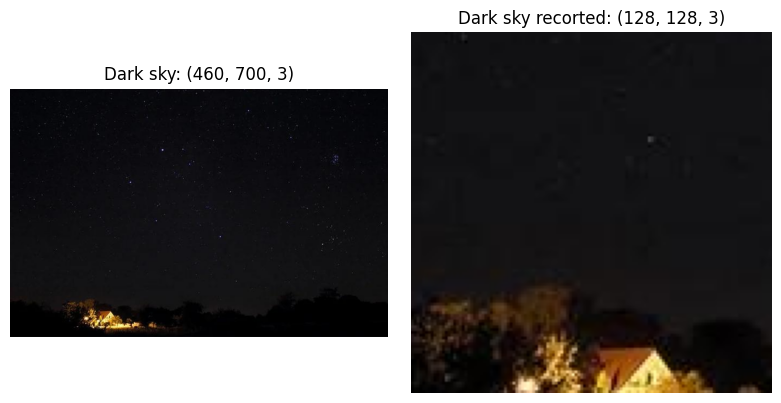

In [174]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(dark_sky_img)
plt.title(f'Dark sky: {dark_sky_img.shape}')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(dark_sky_rec)
plt.title(f'Dark sky recorted: {dark_sky_rec.shape}')
plt.axis('off')
plt.tight_layout()
plt.show()

Extract luminance component in LAB space.

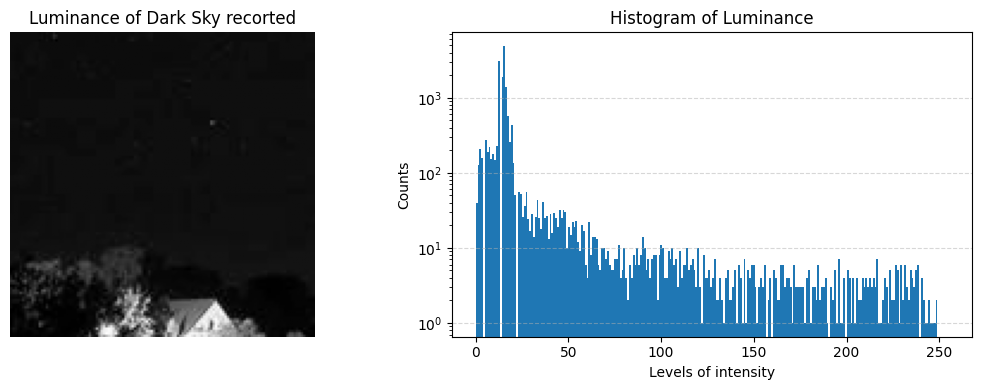

In [175]:
dark_sky_l, dark_sky_a, dark_sky_b = cv.split(cv.cvtColor(dark_sky_rec, cv.COLOR_RGB2LAB))

plt.figure(figsize=(11, 4))
plt.subplot(1, 2, 1)
plt.imshow(dark_sky_l, cmap='gray')
plt.title('Luminance of Dark Sky recorted')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.hist(dark_sky_l.ravel(), bins=256, range=(0, 255))
plt.title('Histogram of Luminance')
plt.xlabel('Levels of intensity')
plt.ylabel('Counts')
plt.yscale('log')
plt.grid(axis='y', ls='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Affect image with blurring

Get a gaussian kernel normalized.

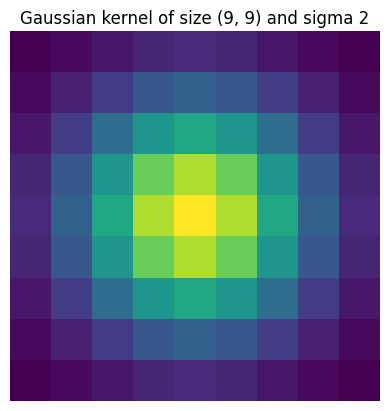

In [176]:
KERNEL_SZ = 9
KERNEL_STD = 2

H = cv.getGaussianKernel(ksize=KERNEL_SZ, sigma=KERNEL_STD)
H = H @ H.T

H = H / np.sum(H)

plt.imshow(H)
plt.axis('off')
plt.title(f'Gaussian kernel of size {H.shape} and sigma {KERNEL_STD}')
plt.show()

Pad a kernel for resize up to image size.

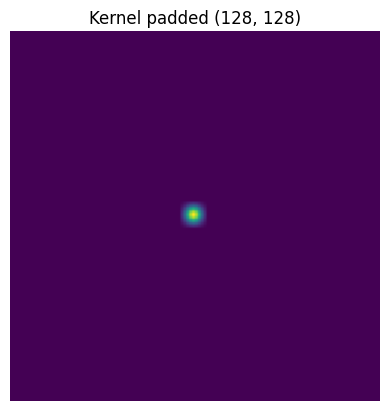

In [177]:
def pad_kernel_to_image_size(H_kernel, image_shape):
    H_padded = np.zeros(image_shape)
    kh, kw = H_kernel.shape
    ih, iw = image_shape

    # Posición para centrar el kernel
    top = (ih - kh) // 2
    left = (iw - kw) // 2

    H_padded[top:top + kh, left:left + kw] = H_kernel
    return H_padded

H_padded = pad_kernel_to_image_size(H, dark_sky_l.shape)

plt.imshow(H_padded)
plt.title(f'Kernel padded {H_padded.shape}')
plt.axis('off')
plt.show()

Apply blurring to luminance.

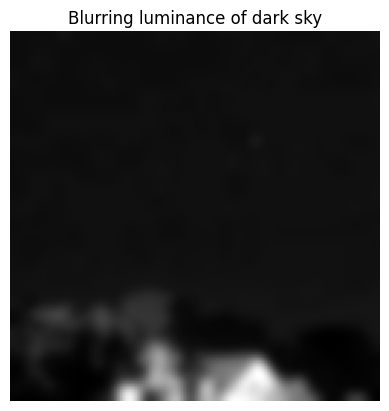

In [178]:
Y = convolve2d(dark_sky_l, H, mode='same', boundary='symm')
Y = (Y - Y.min()) / (Y.max() - Y.min())

plt.imshow(Y, cmap='gray')
plt.title('Blurring luminance of dark sky')
plt.axis('off')
plt.show()

## Deblurring using full matrix

The formulation of problem is:
$$
\frac{1}{2} \Vert H * X - Y \Vert_2^2 + \frac{\rho}{2} \Vert X - Z^k + C^k \Vert_2^2
$$
$$
\begin{alignat}{1}
\nabla_X &= 0
\end{alignat}
$$

The formulation of used steps are:
$$
\begin{gather}
X_{k + 1} = \mathcal{F}^{-1} \Bigg\{ 
\frac{\mathcal{F}\{ H^+ * Y \} - \rho \mathcal{F}\{ C^k - Z^k \}} {\mathcal{F}\{ H^+ * H \} + \rho} 
\Bigg\} \\
\text{where } H^+ = H \text{ rotated 180 degrees}
\end{gather}
$$

Implements the steps:

In [179]:
def soft_thresholding(x, tau):
    return np.sign(x) * np.maximum(np.abs(x) - tau, 0.0)

def normalizer(img):
    img = (img - img.min()) / (img.max() - img.min())
    return img

def admm(H, Y, lambd=0.1, rho=1, max_iter=100, tol=1e-4):
    m, n = Y.shape
    X = Y.copy()
    Z = np.zeros((m, n))
    C = np.zeros((m, n))

    H_frr = fft.fft2(fft.fftshift(H))
    H_rot180 = np.rot90(np.rot90(H))
    H_rot180_frr = fft.fft2(fft.fftshift(H_rot180))
    Y_frr = fft.fft2(Y)

    history = []
    for i in range(max_iter):
        X_old = X.copy()

        # x-update
        x_fourier = ((H_rot180_frr * Y_frr) - rho * fft.fft2(C - Z)) / (H_rot180_frr * H_frr + rho)
        X = fft.ifft2(x_fourier).real
        
        # z-update (soft-thresholding)
        R = X + C
        U, s, Vt = np.linalg.svd(R, full_matrices=False)
        S = np.diag(soft_thresholding(s, lambd / rho))
        Z = U @ S @ Vt

        # c-update
        C += X - Z

        error_mae = np.mean(np.abs(X - X_old))
        history.append(error_mae)
        # Convergence check
        if error_mae < tol:
            break
    
    return normalizer(X), history

In [180]:
def post_process(X_est, ensure_positive=True, clip_outliers=True):
    """Post-process the estimated image for better visualization.
    
    Args:
        X_est: Estimated image
        ensure_positive: Shift values to ensure all are non-negative
        clip_outliers: Clip extreme outliers before normalization
    
    Returns:
        Processed image in [0, 1] range
    """
    # Make a copy to avoid modifying the original
    X_processed = X_est.copy()
    
    # Optionally ensure all values are non-negative
    if ensure_positive:
        X_processed = X_processed - X_processed.min()
    
    # Optionally clip extreme outliers (e.g., beyond 3 standard deviations)
    if clip_outliers:
        mean = X_processed.mean()
        std = X_processed.std()
        X_processed = np.clip(X_processed, mean-3*std, mean+3*std)
    
    # Normalize to [0, 1]
    X_min = X_processed.min()
    X_max = X_processed.max()
    X_processed = (X_processed - X_min) / (X_max - X_min)
    
    return X_processed

In [181]:
X_est, hist_mae = admm(H_padded, Y, lambd=0.01, rho=1, max_iter=10)

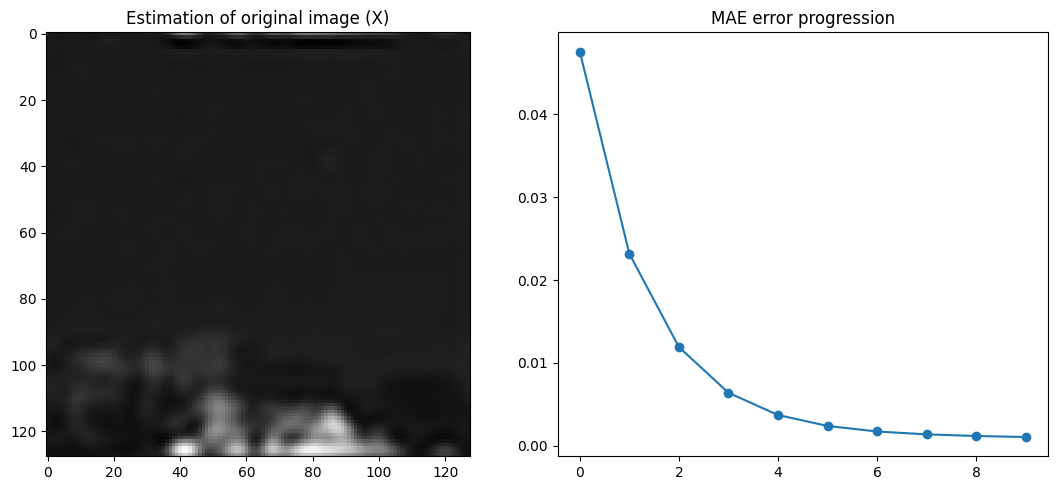

In [182]:
#X_est = post_process(X_est)

plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.imshow(X_est, cmap='gray')
plt.title('Estimation of original image (X)')
plt.subplot(1, 2, 2)
plt.plot(range(len(hist_mae)), hist_mae, marker='o')
plt.title('MAE error progression')

plt.tight_layout()
plt.show()

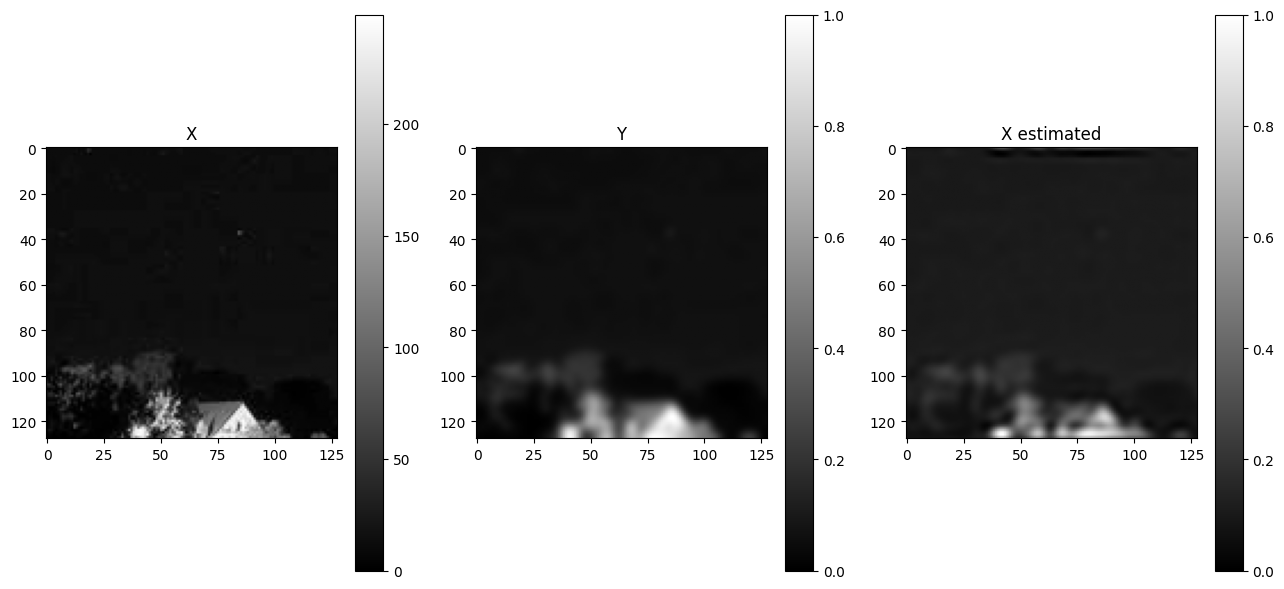

In [183]:
plt.figure(figsize=(13, 6))
plt.subplot(131)
plt.imshow(dark_sky_l, cmap='gray')
plt.colorbar()
plt.title('X')

plt.subplot(132)
plt.title('Y')
plt.imshow(Y, cmap='gray')
plt.colorbar()

plt.subplot(133)
plt.title('X estimated')
plt.imshow(X_est, cmap='gray')
plt.colorbar()

plt.tight_layout()
plt.show()

Compute the errors with the ideal image:

In [184]:
def mae_error(img_est, img_ref):
    mae = np.mean(np.abs(img_est - img_ref))
    return mae
def rmse_error(img_est, img_ref):
    rmse = np.sqrt(np.mean(np.power(img_ref - img_est, 2)))
    return rmse
def compute_errors(img_est, img_ref):
    return mae_error(img_est, img_ref), rmse_error(img_est, img_ref)

Show errors:

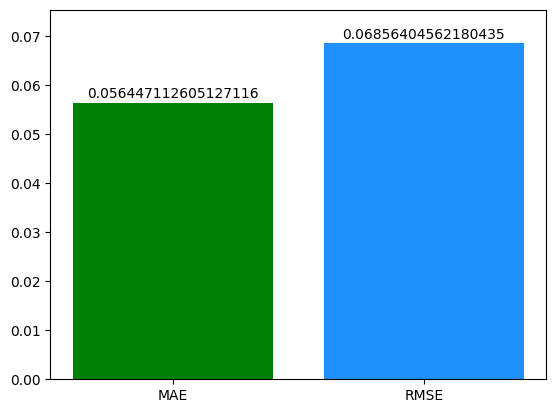

In [185]:
errs = compute_errors(normalizer(dark_sky_l), X_est)
offset = 0.001

plt.bar(['MAE', 'RMSE'], errs, color=['green', 'dodgerblue'])
c = 0
for val in errs:
    plt.text(c, val + offset, str(val), ha='center')
    c += 1
plt.ylim(0, np.max(errs) + np.max(errs) * .1)
plt.show()

## Z-update with patches

In [11]:
from sklearn.feature_extraction.image import extract_patches_2d
import numpy as np

def extract_similar_patches(X, patch_size=8, num_neighbors=60, search_window=30):
    # 1. Extract all patches
    all_patches = extract_patches_2d(X, (patch_size, patch_size))
    h, w = X.shape
    
    # Calculate how many patches fit in each row and column
    patches_per_row = w - patch_size + 1
    patches_per_col = h - patch_size + 1
    
    # Initialize the result list
    similar_groups = []
    
    # For each patch position
    for i in range(patches_per_col):
        for j in range(patches_per_row):
            # Current patch index
            current_idx = i * patches_per_row + j
            current_patch = all_patches[current_idx].flatten()
            
            # Find neighbor patches within the search window
            neighbor_indices = []
            for ni in range(max(0, i - search_window), min(patches_per_col, i + search_window + 1)):
                for nj in range(max(0, j - search_window), min(patches_per_row, j + search_window + 1)):
                    neighbor_idx = ni * patches_per_row + nj
                    neighbor_indices.append(neighbor_idx)
            
            # Get these patches
            neighbor_patches = all_patches[neighbor_indices].reshape(len(neighbor_indices), -1)
            
            # Calculate distances to the current patch
            distances = np.sum((neighbor_patches - current_patch)**2, axis=1)
            
            # Find the closest patches
            closest_indices = np.argsort(distances)[:num_neighbors]
            similar_patch_indices = [neighbor_indices[idx] for idx in closest_indices]
            
            # Group the similar patches
            group = all_patches[similar_patch_indices].reshape(num_neighbors, -1).T
            similar_groups.append(group)
    
    return similar_groups

In [12]:
def aggregate_patches(similar_groups, patch_size, image_shape):
    """
    Reconstructs an image from patch groups using only the reference patches.
    
    Args:
        similar_groups: List of patch groups where each group is a matrix with patches as columns
        patch_size: Size of each patch (e.g., 8 for 8x8 patches)
        image_shape: Shape of the output image (height, width)
    
    Returns:
        Reconstructed image
    """
    h, w = image_shape
    patches_per_row = w - patch_size + 1
    
    # Initialize arrays for accumulation and counting
    accumulated = np.zeros(image_shape)
    counts = np.zeros(image_shape)
    
    # Process each patch group
    for idx, group in enumerate(similar_groups):
        # Get the reference patch (first column)
        base_patch = group[:, 0].reshape(patch_size, patch_size)
        
        # Calculate original position
        i = idx // patches_per_row
        j = idx % patches_per_row
        
        # Add patch values to the accumulated array
        accumulated[i:i+patch_size, j:j+patch_size] += base_patch
        
        # Count how many times each pixel is covered
        counts[i:i+patch_size, j:j+patch_size] += 1
    
    # Avoid division by zero
    counts[counts == 0] = 1
    
    # Average the accumulated values
    reconstructed = accumulated / counts
    
    return reconstructed

In [13]:
def z_update(X_plus_C, patch_size=8, num_neighbors=15, search_window=10, lambd=0.1, rho=1.0):
    """
    Performs the Z-update step in ADMM using SVD and soft thresholding on patch groups.
    
    Args:
        X_plus_C: Matrix X + C from ADMM algorithm
        patch_size: Size of patches 
        num_neighbors: Number of similar patches to group
        search_window: Window size for searching similar patches
        lambd: Regularization parameter
        rho: ADMM parameter
    
    Returns:
        Updated Z matrix
    """
    # 1. Extract similar patch groups
    similar_groups = extract_similar_patches(X_plus_C, patch_size, num_neighbors, search_window)
    
    # 2. Process each group with SVD + thresholding
    processed_groups = []
    for group in similar_groups:
        # Apply SVD
        U, s, Vt = np.linalg.svd(group, full_matrices=False)
        
        # Apply soft thresholding to singular values
        s_thresholded = soft_thresholding(s, lambd / rho)
        
        # Reconstruct the group
        S = np.diag(s_thresholded)
        group_processed = U @ S @ Vt
        processed_groups.append(group_processed)
    
    # 3. Aggregate patches to form Z
    Z = aggregate_patches(processed_groups, patch_size, X_plus_C.shape)
    
    return Z

In [16]:
from tqdm.notebook import tqdm

def admm(H, Y, lambd=0.1, rho=1.0, max_iter=100, tol=1e-4):
    m, n = Y.shape
    X = Y.copy()  # Initial solution
    Z = np.zeros((m, n))
    C = np.zeros((m, n))

    Hf = np.fft.fft2(H)
    Hcc = np.conjugate(Hf)
    H_dot_Y = Hcc * np.fft.fft2(Y)
    Hcc_dot_H = np.abs(Hf)**2

    # Store norms for plotting convergence  
    norms = []
    
    # Create a progress bar
    pbar = tqdm(total=max_iter, desc="ADMM Progress")
    
    for i in range(max_iter):
        X_old = X.copy()

        # x-update in Fourier domain
        M = np.fft.fft2(Z-C)
        Xf = (H_dot_Y + rho * M) / (Hcc_dot_H + rho + 1e-8) # 1e-8 for numerical stability
        X = np.fft.ifft2(Xf).real

        # z-update (soft-thresholding)
        R = X + C
        Z = z_update(R, lambd=lambd, rho=rho)

        # c-update
        C += X - Z
        
        # Calculate convergence metric
        norm_diff = np.linalg.norm(X - X_old)
        norms.append(norm_diff)

        # Update progress bar with current norm
        pbar.set_postfix({"norm": f"{norm_diff:.6f}"})
        pbar.update(1)

        # Convergence check
        if norm_diff < tol:
            break
            
    pbar.close()
    return np.fft.fftshift(X), norms

In [17]:
X_est, norms = admm(H_padded, Y, lambd=0.1, max_iter=200)
X_est = post_process(X_est)

ADMM Progress:   0%|          | 0/200 [00:00<?, ?it/s]

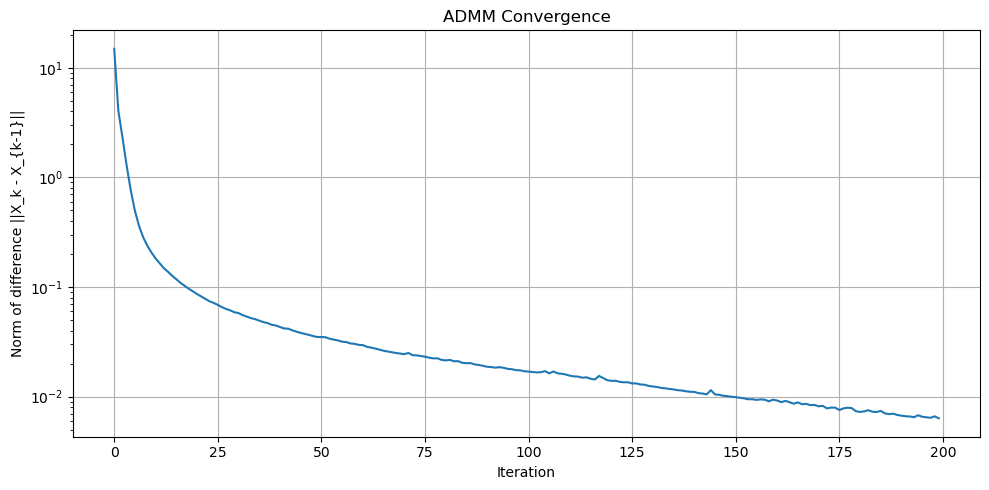

In [18]:
plt.figure(figsize=(10, 5))
plt.semilogy(norms)  # Use semilogy for better visualization of convergence
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Norm of difference ||X_k - X_{k-1}||')
plt.title('ADMM Convergence')
plt.tight_layout()
plt.show()

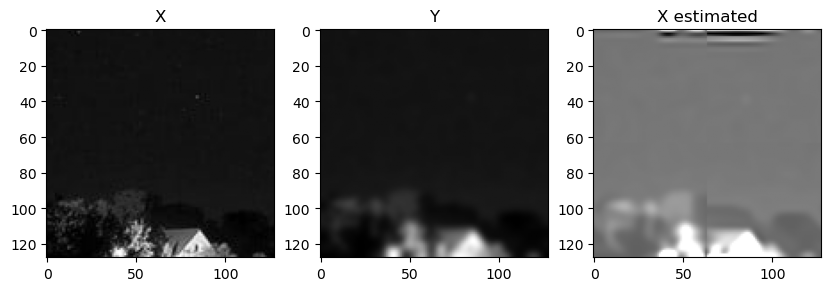

In [19]:
plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.imshow(X, cmap='gray')
plt.title('X')
plt.subplot(132)
plt.title('Y')
plt.imshow(Y, cmap='gray')
plt.subplot(133)
plt.title('X estimated')
plt.imshow(X_est, cmap='gray')
plt.show()